# Mixtures of Gaussian processes with GPclust


This notebook accompanies the paper

**Nonparameteric Clustering of Structured Time Series**  
_James Hensman, Magnus Rattray and Neil D. Lawrence_  
IEEE TPAMI 2014

The code is available at <https://github.com/mathDR/gpclust> . The GPclust module depends on [GPflow](https://github.com/GPflow).  

The hierachical Gaussian process model was fleshed out in 

**Hierarchical Bayesian modelling of gene expression time series  
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_

http://www.biomedcentral.com/1471-2105/14/252

A simple implementation of hierarchical GPs is available as part of GPflow. 


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import GPclust
import GPflow

## A simple sinusoid dataset

Here's a simulated dataset that contains the simple features that we expect to have in real data sets: smooth processes (here, sinusoids) corrupted by further smooth processes (here, more sinusoids) as well as noise. 

In [2]:
#generate a data set. Here's the sinusoid demo from the manuscript.
Nclust = 10
Nx = 12
Nobs = [np.random.randint(20,31) for i in range(Nclust)] #a random number of realisations in each cluster
X = np.random.rand(Nx,1)
X.sort(0)

#random frequency and phase for each cluster
base_freqs = 2*np.pi + 0.3*(np.random.rand(Nclust)-.5)
base_phases = 2*np.pi*np.random.rand(Nclust)
means = np.vstack([np.tile(np.sin(f*X+p).T,(Ni,1)) for f,p,Ni in zip(base_freqs,base_phases,Nobs)])

#add a lower frequency sinusoid for the noise
freqs = .4*np.pi + 0.01*(np.random.rand(means.shape[0])-.5)
phases = 2*np.pi*np.random.rand(means.shape[0])
offsets = 0.3*np.vstack([np.sin(f*X+p).T for f,p in zip(freqs,phases)])
Y = means + offsets + np.random.randn(*means.shape)*0.05

In the plot below, we show the underlying function for each cluster as a smooth red function, and the data associated with the cluster as thinly connected blue crosses. 

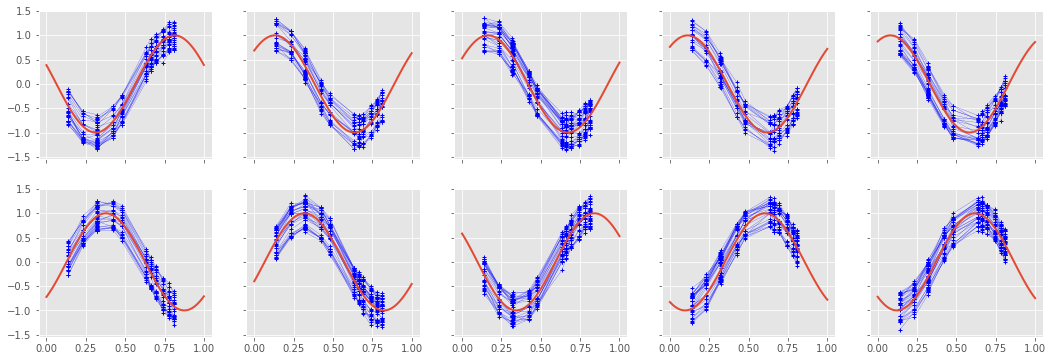

In [3]:
#plotting. 
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
f, axes = plt.subplots(2, Nclust//2, figsize=(18,6), sharex=True, sharey=True)
index_starts = np.hstack([0, np.cumsum(Nobs[:-1])])
index_stops = np.cumsum(Nobs)
for n, ax in enumerate(axes.flatten()):
    ax.plot(X, Y[index_starts[n]:index_stops[n]].T, 'b', marker='+',ms=4, mew=1, linewidth=0.2)
    ax.plot(x_plot, np.sin(base_freqs[n]*x_plot+base_phases[n]), linewidth=2)
    

Constructing and optimizing a model
---

Now that we have generated a data set, it's straightforward to build and optimize a clustering model. First, we need to build two GPy kernels (covariance functions), which will be used to model the underlying function and the replication noise, respecively. We'll take a wild stab at the parameters of these covariances, and let the model optimize them for us later. 

The two kernels model the *underlying* function of the cluster, and the deviations of each gene from that underlying function. If we believe that the only corruption of the data from the cluster mean is i.i.d. noise, we can specify a `GPy.kern.White` covariance. In practice, it's helpful to allow correlated noise. The model of any cluster of genes then has a hierarchical structure, with the unknown cluster-specific mean drawn from a GP, and then each gene in that cluster being drawn from a GP with said unknown mean function. 

To optimize the model with the default optimization settings, we call `m.optimize()`. To invoke the recommended merge-split procedure, call `m.systematic_splits()`. Note that during the splitting procedure, many calls are made to the optimize function. 

In [4]:
print(X.shape, Y.shape)

(12, 1) (257, 12)


In [5]:
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.RBF(input_dim=1, variance=0.01, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.001)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

AttributeError: module 'GPflow.tf_wraps' has no attribute 'eye'

In [5]:
m.log_likelihood()

2818.3146125647845

Plotting and examining the posterior
---
The model has quite extensive plotting built in, with various options for color, display of the data as points or connected lines, etc. Here we find that the model manages to separate all but two of the true clusters. The number of 'genes' found in each cluster is labeled in the corner of each plot. 

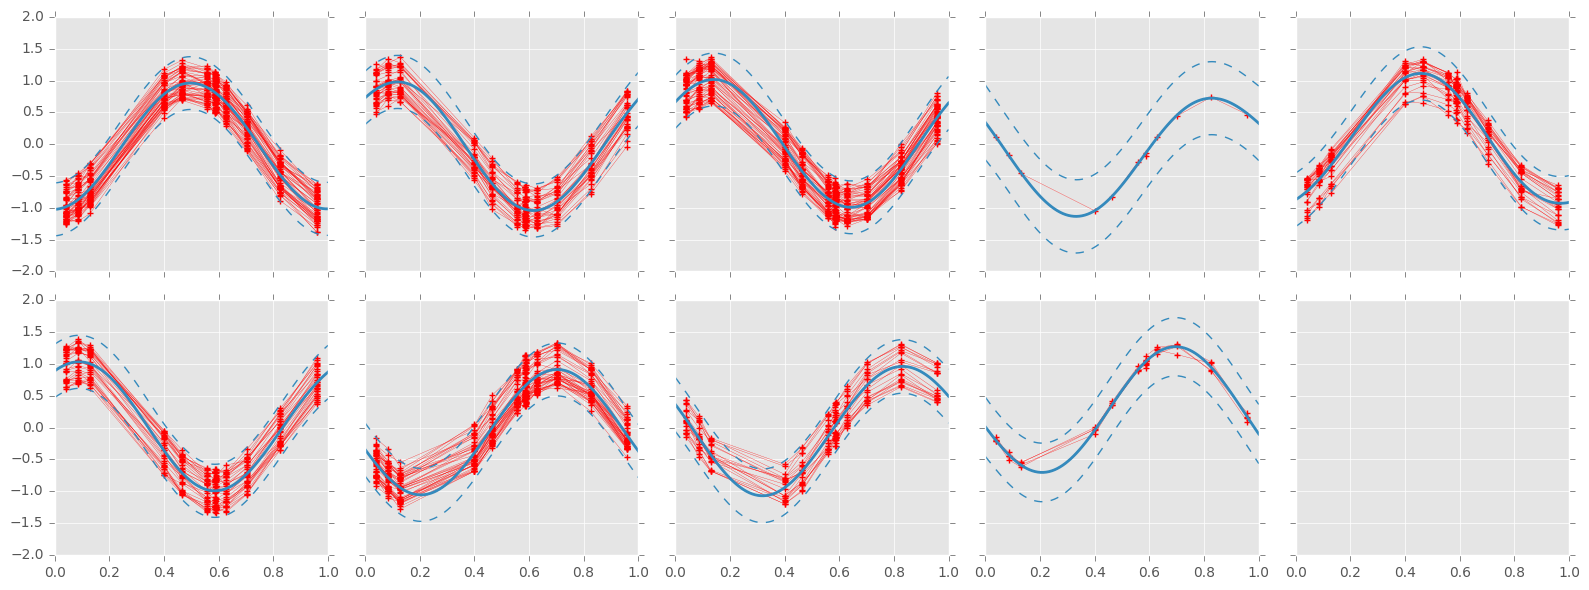

In [8]:
def plot(layout=None, figsize=(12,12)):
    if layout is None:
        num_x = int(np.ceil(np.sqrt(m.num_clusters)))
        num_y = m.num_clusters // num_x
    else:
        num_x, num_y = layout
    f, axes = plt.subplots(num_x, num_y, figsize=figsize, sharex=True, sharey=True, tight_layout=True)
    
    x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
    mu, var = m.predict_components(x_plot)
    phi = m.get_phi()
    
    for i, (mu_i, var_i, ax), in enumerate(zip(mu, var, axes.flatten())):
        ax.plot(x_plot[:,0], mu_i)

        ind = np.argmax(phi, 1) == i
        if np.any(ind):
            ax.plot(X, Y[ind, :].T, 'r', ms=4, mew=1, marker='+', lw=0.2)
        line, = ax.plot(x_plot[:,0], mu_i, lw=2)
        ax.plot(x_plot[:,0], mu_i[:,0] + 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
        ax.plot(x_plot[:,0], mu_i[:,0] - 2*np.sqrt(np.diag(var_i)), '--', lw=1, color=line.get_color())
plot((2,5), (16,6))

Structure is important
---
Why do we have to specify two kernels in GPclust? The first kernel describes the properties of the functions which underly each cluster. The second describes the properties of the functions which describe how each time-course (gene) deviates from the cluster. 

This structure is important: if we model the deviation of each time-course from the cluster as simply noise, it's more difficult to infer the correct clusters. Such a model can be constructed in GPclust by using a white (noise) kernel for the structure, as follows.


In [9]:
#exactly as above, but with a white-noise kernel for the structure.
k_underlying = GPflow.kernels.RBF(input_dim=1, variance=0.1, lengthscales=0.1)
k_corruption = GPflow.kernels.White(1, variance=0.1)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, num_clusters=10, prior_Z='symmetric', alpha=1.0)
m.optimize()

iteration 1 bound=-1504.00812013 grad=3262.9480418, beta=0
iteration 2 bound=-541.317276821 grad=8026.22497218, beta=0.369680040574
iteration 3 bound=-512.766194097 grad=147.266459547, beta=0.0
iteration 4 bound=-510.075353023 grad=42.2986968566, beta=0.525700580806
iteration 5 bound=-510.075351277 grad=1.9186598072e-06, beta=2.10550675285e-07
iteration 6 bound=-510.075350047 grad=1.32174527568e-06, beta=0.0
iteration 7 bound=-510.075349111 grad=9.92588447183e-07, beta=0.0
vb converged (ftol)
vb converged (gtol)


In [10]:
m.systematic_splits(verbose=False)

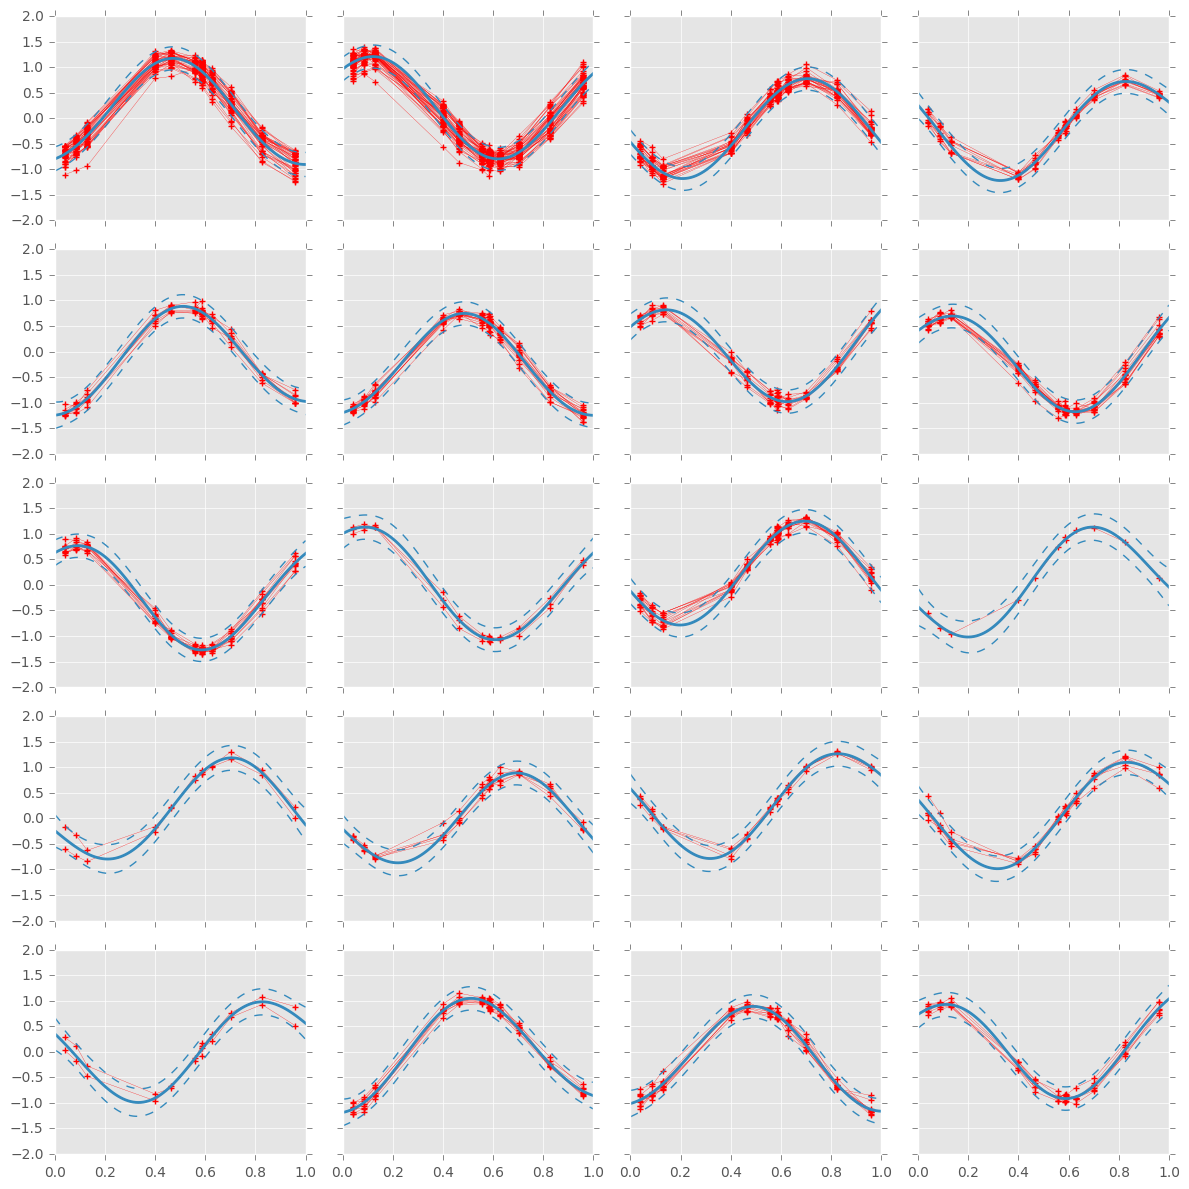

In [11]:
plot()

Here we can see that the procedure finds too many clusters (we know that the ground truth is that there are 10). This is because without the ability to model the deviation from the cluster mean in a structured fashion, that structure appears as additional clusters. 

This point is exaggerated a little by the toy data that we have generated, but the same issue exists in real data. For more details and consideration of the cluster structure, see the subsequent notebook on clustering Drosophila development. 